# Traffic Sign Classification with Convolutional Neural Networks by TensorFlow

This is a George Mason University SWE 645 course project.<br>
Topic: Traffic Sign Classification with Convolutional Neural Networks by TensorFlow<br>
Reference research: Sermanet, P. and LeCun, Y. Traffic Sign Recognition with Multi-Scale Convolutional Networks
    yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf<br>
Dataset: German Traffic Sign Benchmark<br>
    http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset<br>
    https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign<br>
Object: In the research paper, it states several Convolutional Neural Network models to do the recognition and classification for German Traffic Sign. It uses a C++ package and Matlab to implement. The highest accuracy is above 99%. So now I would like to implement a CNN model by using TensorFlow and OpenCV to achieve at least 95% accuracy.

# 1. Preprocess the data image
According to Pierre Sermanet and Yann LeCun, color image actually doesn't help a lot. So I choose only work on gray image. The preprocess steps include: crop and resize the image to 48x48, transfer color image into gray, smooth the image by Gaussian Blur, equalize the image histogram, and finally normalize it.

In [ ]:
import os
import cv2
import numpy as np
import shutil
import pandas as pd
import PIL.Image as Image

Define crop and resize image function. In this function, current .csv file would be read, and we get image file path, ROI region, and class id. We process the image and then save new images to a new file path with a new .csv file.

In [ ]:
def crop_and_resize_image(csv_file_from_path, csv_file_to_path, dir_to_path, width, height):
    # if cvs_file_path does exist, throw exception
    if not os.path.exists(csv_file_from_path):
        raise ImportError

    # if dir_to_path does not exist, then create one; if exist, remove and recreate
    if not os.path.exists(dir_to_path):
        os.makedirs(dir_to_path)
    else:
        shutil.rmtree(dir_to_path)
        os.makedirs(dir_to_path)

    # read csv file
    print("Using: " + csv_file_from_path)
    annotations = pd.read_csv(csv_file_from_path, header=0)
    index = annotations.index.tolist()
    annotations = annotations.set_index([index])
    print(annotations)

    # record new file path and class save to new .csv file
    new_file_name_collection = []
    new_class_name_collection = []

    # iterate the image listed in .csv file
    for i in range(len(annotations)):
        # read image path and make new path
        image_file_path = annotations.at[i, 'Path']
        image_file_path = "./" + image_file_path
        image_new_file_path = os.path.join(dir_to_path, image_file_path.split('/')[-1])
        print("Current processing: " + image_new_file_path)

        # read ROI region
        x1 = annotations.at[i, 'Roi.X1']
        y1 = annotations.at[i, 'Roi.Y1']
        x2 = annotations.at[i, 'Roi.X2']
        y2 = annotations.at[i, 'Roi.Y2']

        # crop and resize region
        image = Image.open(image_file_path)
        image = image.crop((x1, y1, x2, y2))
        image = image.resize((width, height), resample=Image.BILINEAR)
        image.save(image_new_file_path)

        # equalize and normalize image
        image = cv2.imread(image_new_file_path)
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        cv2.imwrite(image_new_file_path, gray_img)
        equalize_normalize_images(image_new_file_path, width, height)

        # record class id
        classId = annotations.at[i, 'ClassId']
        new_file_name_collection.append(image_new_file_path)
        new_class_name_collection.append(classId)

    # save new image file path and new class id to new .csv file
    df = pd.DataFrame({'file': new_file_name_collection,
                       'class': new_class_name_collection})
    df.to_csv(path_or_buf=csv_file_to_path, index=False)


In [ ]:
def equalize_normalize_images(image_path, width, height):
    image = cv2.imread(image_path, 0)

    # Gaussian filtering
    blur_img = cv2.GaussianBlur(image, (5, 5), 0)

    # equalize the histogram
    equalized_img = cv2.equalizeHist(blur_img)

    # normalize the image
    normalized_img = np.zeros((width, height))
    normalized_img = cv2.normalize(equalized_img, normalized_img, 0, 255, cv2.NORM_MINMAX)

    cv2.imwrite(image_path, normalized_img)


2. Extend the preprocessed data image<br>
In reality, the captured traffic sign might be scaled or rotated in a different way. In order to recognize those images, we can randomly perturbe the preprocessed image in position ([-2,2] pixels), in scale ([.9,1.1] ratio) and rotation ([-10,+10] degrees).

Import random to generate number number

In [ ]:
import random
import time

In [ ]:
def crop_and_resize_image_extend(csv_file_from_path, csv_file_to_path, dir_to_path, width, height):
    # if cvs_file_path does exist, throw exception
    if not os.path.exists(csv_file_from_path):
        raise ImportError

    # if dir_to_path does not exist, then create one; if exist, remove and recreate
    if not os.path.exists(dir_to_path):
        os.makedirs(dir_to_path)
    else:
        shutil.rmtree(dir_to_path)
        os.makedirs(dir_to_path)

    # read csv file
    print("Using: " + csv_file_from_path)
    annotations = pd.read_csv(csv_file_from_path, header=0)
    index = annotations.index.tolist()
    annotations = annotations.set_index([index])
    print(annotations)

    # record new file path and class save to new .csv file
    new_file_name_collection = []
    new_class_name_collection = []

    # iterate the image listed in .csv file
    for i in range(len(annotations)):
        # read image path and make new path
        image_file_path = annotations.at[i, 'Path']
        image_sub_file_path = image_file_path.split('/')[-1]
        image_name = image_sub_file_path.split('.')[0]
        image_new_name_1 = image_name + "_01.png"
        image_new_name_2 = image_name + "_02.png"
        image_new_name_3 = image_name + "_03.png"
        image_new_file_path_1 = os.path.join(dir_to_path, image_new_name_1)
        image_new_file_path_2 = os.path.join(dir_to_path, image_new_name_2)
        image_new_file_path_3 = os.path.join(dir_to_path, image_new_name_3)

        # read ROI region
        x1 = annotations.at[i, 'Roi.X1']
        y1 = annotations.at[i, 'Roi.Y1']
        x2 = annotations.at[i, 'Roi.X2']
        y2 = annotations.at[i, 'Roi.Y2']

        # crop and resize region
        random_shift(image_file_path, image_new_file_path_1, width, height, x1, y1, x2, y2)
        random_scale(image_file_path, image_new_file_path_2, width, height, x1, y1, x2, y2)
        random_rotate(image_file_path, image_new_file_path_3, width, height, x1, y1, x2, y2)

        # equalize and normalize image
        equalize_normalize_images(image_new_file_path_1, width, height)
        equalize_normalize_images(image_new_file_path_2, width, height)
        equalize_normalize_images(image_new_file_path_3, width, height)

        # record class id
        classId = annotations.at[i, 'ClassId']
        new_file_name_collection.append(image_new_file_path_1)
        new_class_name_collection.append(classId)
        new_file_name_collection.append(image_new_file_path_2)
        new_class_name_collection.append(classId)
        new_file_name_collection.append(image_new_file_path_3)
        new_class_name_collection.append(classId)

    # save new image file path and new class id to new .csv file
    df = pd.DataFrame({'file': new_file_name_collection,
                       'class': new_class_name_collection})
    df.to_csv(path_or_buf=csv_file_to_path, index=False)
    

In [ ]:
def random_rotate(image_file_path, image_new_file_path, width, height, x1, y1, x2, y2):
    # set current time to random seed
    random.seed(time.time())

    # generate random parameters
    delta_rotation = random.randint(-10, 11)

    img = cv2.imread(image_file_path)
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    M = cv2.getRotationMatrix2D((width / 2, height / 2), delta_rotation, 1.0)
    rotated_img = cv2.warpAffine(image, M, (width, height))
    rotated_img_height, rotated_img_width = rotated_img.shape

    i = 0
    while not (0 <= x1 <= rotated_img_width and 0 <= x2 <= rotated_img_width and \
               0 <= y1 <= rotated_img_height and 0 <= y2 <= rotated_img_height):
        delta_rotation = random.randint(-10, 11)
        M = cv2.getRotationMatrix2D((width / 2, height / 2), delta_rotation, 1.0)
        rotated_img = cv2.warpAffine(image, M, (width, height))
        rotated_img_height, rotated_img_width = rotated_img.shape

        # avoid infinite loop
        i += 1
        if i > 100:
            cropped_img = img[y1: y2][x1: x2]
            resized_img = cv2.resize(cropped_img, (width, height))
            cv2.imwrite(image_new_file_path, resized_img)
            return

    cropped_img = rotated_img[y1: y2][x1: x2]
    resized_img = cv2.resize(cropped_img, (width, height))
    cv2.imwrite(image_new_file_path, resized_img)


def random_shift(image_file_path, image_new_file_path, width, height, x1, y1, x2, y2):
    # set current time to random seed
    random.seed(time.time())

    # generate random parameters
    delta_x = random.randint(-2, 3)
    delta_y = random.randint(-2, 3)

    img = cv2.imread(image_file_path)
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    image_height, image_width = image.shape

    i = 0
    while not (0 <= x1 + delta_x <= image_width and 0 <= x2 + delta_x <= image_width and \
               0 <= y1 + delta_y <= image_height and 0 <= y2 + delta_y <= image_height):
        delta_x = random.randint(-2, 3)
        delta_y = random.randint(-2, 3)

        # avoid infinite loop
        i += 1
        if i > 100:
            cropped_img = img[y1: y2][x1: x2]
            resized_img = cv2.resize(cropped_img, (width, height))
            cv2.imwrite(image_new_file_path, resized_img)
            return

    new_x1 = x1 + delta_x
    new_y1 = y1 + delta_y
    new_x2 = x2 + delta_x
    new_y2 = y2 + delta_y

    cropped_img = image[new_y1: new_y2][new_x1: new_x2]
    resized_img = cv2.resize(cropped_img, (width, height))
    cv2.imwrite(image_new_file_path, resized_img)


def random_scale(image_file_path, image_new_file_path, width, height, x1, y1, x2, y2):
    # set current time to random seed
    random.seed(time.time())

    # generate random parameters
    delta_scale = random.uniform(0.9, 1.1)

    img = cv2.imread(image_file_path)
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_img = cv2.resize(image, (0, 0), fx=delta_scale, fy=delta_scale)
    scaled_img_height, scaled_img_width = scaled_img.shape

    i = 0
    while not (0 <= x1 <= scaled_img_width and 0 <= x2 <= scaled_img_width and \
               0 <= y1 <= scaled_img_height and 0 <= y2 <= scaled_img_height):
        delta_scale = random.uniform(0.9, 1.1)
        scaled_img = cv2.resize(image, (0, 0), fx=delta_scale, fy=delta_scale)
        scaled_img_height, scaled_img_width = scaled_img.shape

        # avoid infinite loop
        i += 1
        if i > 100:
            cropped_img = img[y1: y2][x1: x2]
            resized_img = cv2.resize(cropped_img, (width, height))
            cv2.imwrite(image_new_file_path, resized_img)
            return

    cropped_img = scaled_img[y1: y2][x1: x2]
    resized_img = cv2.resize(cropped_img, (width, height))
    cv2.imwrite(image_new_file_path, resized_img)

# Result of Pre-process

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

def plot_images(file_path, row, col):
    fig = plt.figure(figsize=(8, 8))
    i = 1
    for image_name in os.listdir(file_path):
        if i >= row*col + 1:
            break
        if image_name.endswith('.png'):
            img = cv2.imread(os.path.join(file_path, image_name))
            fig.add_subplot(row, col, i)
            plt.imshow(img)
            i += 1
    plt.show()

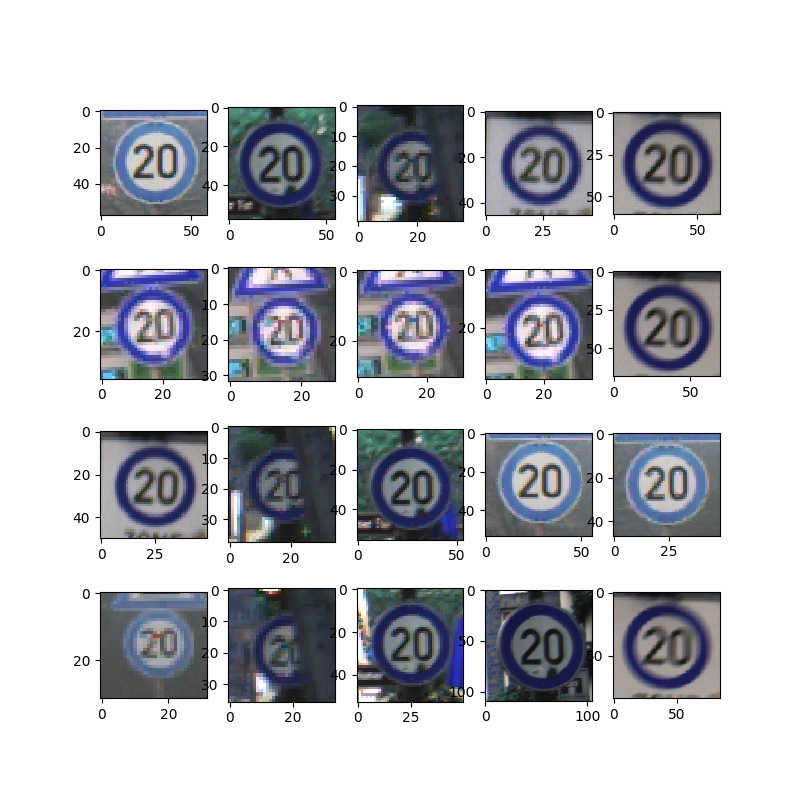

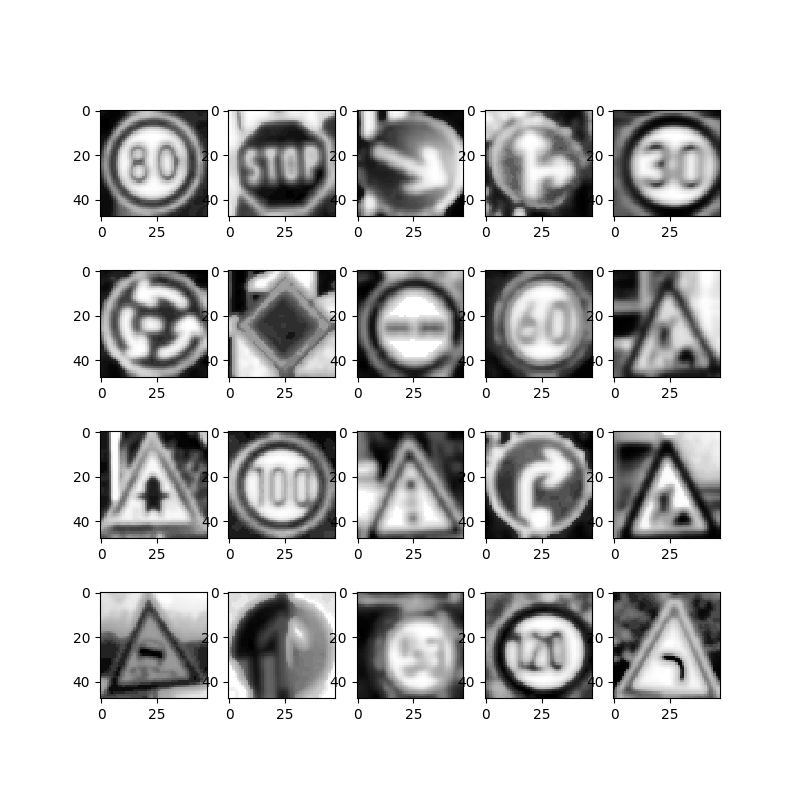

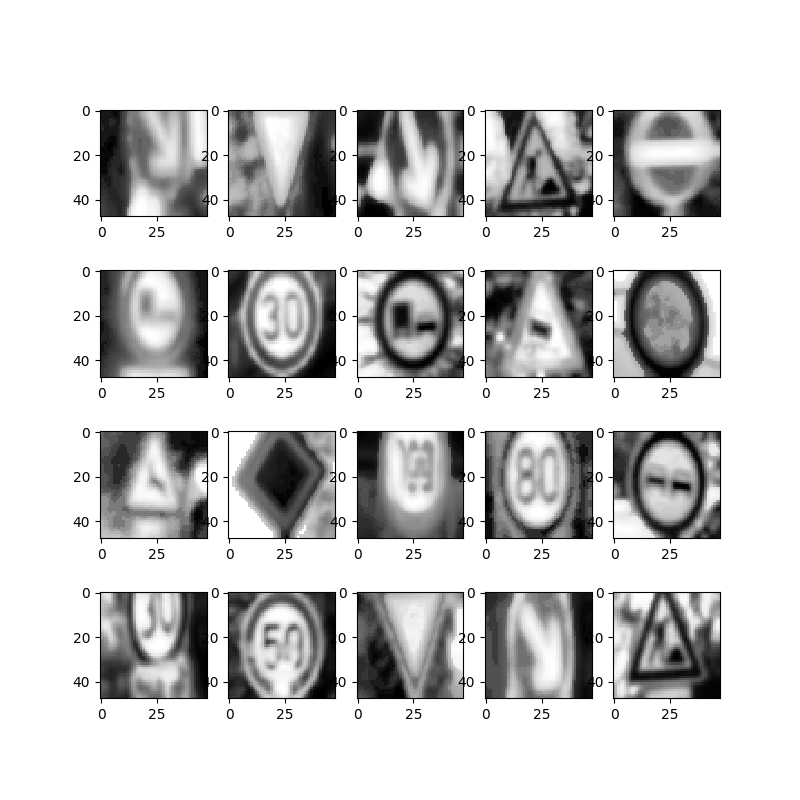

# 2. Build trainning model

According to the research, # 178 -- 2 layers ConvNet with 108 features and 108 features could reach 98.97% accuracy. However, limited by my machine's computing ability, I choose to mock # 26 -- 2 layers ConvNet with 38 features and 64 features, which theoretically could reach 98.89% accuracy. However, I'm going to add another layer. So my model would be 3 layers ConvNet with 16 features, 32 features, and 64 features.

First to build read data function

In [ ]:
import numpy as np
import pandas as pd
import cv2


def read_data(csv_file_path):
    # open .csv file
    annotations = pd.read_csv(csv_file_path)
    rows, cols = annotations.shape

    image_path_collection = []
    image_class_collection = []

    # read data in row
    for i in range(rows):
        image_path = annotations.at[i, 'file']
        image_class = annotations.at[i, 'class']
        image_path_collection.append(image_path)
        class_array = np.zeros(43)
        class_array[int(image_class)] = 1
        image_class_collection.append(class_array)

    print("Input image size: " + str(len(image_path_collection)))
    print("Input label size: " + str(len(image_class_collection)))

    # load image in memory
    image_collection = []
    for i in range(len(image_path_collection)):
        image = cv2.imread(image_path_collection[i])
        image_array = np.array(image[:, :, 0])
        image_array_flatten = image_array.flatten()
        image_collection.append(image_array_flatten)

    if len(image_collection) == len(image_class_collection):
        return np.array(image_collection), np.array(image_class_collection)
    else:
        raise ImportError


def next_batch(num, data, labels):
    # random shuffle data and labels
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

Then define the trainning model

In [ ]:
import tensorflow as tf
import time

def init_train():
    tf.set_random_seed(time.time())
    np.random.seed(int(time.time()))

    BATCH_SIZE = 500
    LR = 0.001

    tf_x = tf.placeholder(tf.float32, [None, 48 * 48]) / 255.
    image = tf.reshape(tf_x, [-1, 48, 48, 1])
    tf_y = tf.placeholder(tf.int32, [None, 43])

    # CNN
    conv1 = tf.layers.conv2d(inputs=image, filters=16, kernel_size=5, strides=1,
                             padding='same', activation=tf.nn.relu)
    # -> (48*48*16)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)
    pool1_drop = tf.nn.dropout(pool1, rate=0.1)
    # -> (24*24*16)
    conv2 = tf.layers.conv2d(inputs=pool1_drop, filters=32, kernel_size=5, strides=1,
                             padding='same', activation=tf.nn.relu)
    # -> (24*24*32)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
    pool2_drop = tf.nn.dropout(pool2, rate=0.2)
    # -> (12*12*32)
    conv3 = tf.layers.conv2d(pool2_drop, 64, 5, 1, 'same', activation=tf.nn.relu)
    # -> (12*12*64)
    pool3 = tf.layers.max_pooling2d(conv3, 2, 2)
    pool3_drop = tf.nn.dropout(pool3, rate=0.3)

    # -> (6*6*64)
    flat = tf.reshape(pool3_drop, [-1, 6 * 6 * 64])
    output = tf.layers.dense(flat, 43)

    # calculate loss
    loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)

    # calculate accuracy
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(tf_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # initial session
    saver = tf.train.Saver()
    config = tf.ConfigProto()
    config.intra_op_parallelism_threads = 4
    config.inter_op_parallelism_threads = 4

    sess = tf.Session(config=config)
    init = tf.global_variables_initializer()
    sess.run(init)

    xs_i, ys_i = read_data('./Train_processed.csv')
    test_xs, test_ys = read_data('./Test_processed.csv')

    for step in range(10001):
        batch_xs, batch_ys = next_batch(BATCH_SIZE, xs_i, ys_i)
        _, loss_ = sess.run([train_op, loss], {tf_x: batch_xs, tf_y: batch_ys})
        if step % 50 == 0:
            accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_xs, tf_y: test_ys})
            print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.4f' % accuracy_)
            saver.save(sess, './checkpoint_dir/MyModel')


# Output

As we can see, with 39209 train image and 12630 test image input, the model could reach 90% accuracy within 500 iterations with BATCH_SIZE = 500. After 93%, the accuracy seems like fluctuate and doesn't go up fast. But it still achieved 95%. Let's add the extend image data to see what will happen.

In [ ]:
Input image size: 39209
Input label size: 39209
Input image size: 12630
Input label size: 12630
Step: 0 | train loss: 94.2342 | test accuracy: 0.0426
Step: 50 | train loss: 2.7441 | test accuracy: 0.2702
Step: 100 | train loss: 1.1946 | test accuracy: 0.6002
Step: 150 | train loss: 0.7999 | test accuracy: 0.7458
Step: 200 | train loss: 0.4283 | test accuracy: 0.8087
Step: 250 | train loss: 0.3181 | test accuracy: 0.8489
Step: 300 | train loss: 0.2166 | test accuracy: 0.8793
Step: 350 | train loss: 0.1508 | test accuracy: 0.8888
Step: 400 | train loss: 0.2035 | test accuracy: 0.8983
Step: 450 | train loss: 0.1580 | test accuracy: 0.9019
Step: 500 | train loss: 0.1309 | test accuracy: 0.9101
Step: 550 | train loss: 0.1110 | test accuracy: 0.9159
Step: 600 | train loss: 0.0824 | test accuracy: 0.9188
Step: 650 | train loss: 0.0439 | test accuracy: 0.9241
Step: 700 | train loss: 0.0496 | test accuracy: 0.9268
Step: 750 | train loss: 0.0598 | test accuracy: 0.9300
Step: 800 | train loss: 0.0494 | test accuracy: 0.9330
Step: 850 | train loss: 0.0863 | test accuracy: 0.9333
Step: 900 | train loss: 0.0231 | test accuracy: 0.9356
Step: 950 | train loss: 0.0719 | test accuracy: 0.9409
Step: 1000 | train loss: 0.0346 | test accuracy: 0.9395
Step: 1050 | train loss: 0.0660 | test accuracy: 0.9371
Step: 1100 | train loss: 0.0457 | test accuracy: 0.9379
Step: 1150 | train loss: 0.0202 | test accuracy: 0.9432
Step: 1200 | train loss: 0.0265 | test accuracy: 0.9412
Step: 1250 | train loss: 0.0283 | test accuracy: 0.9463
Step: 1300 | train loss: 0.0331 | test accuracy: 0.9458
Step: 1350 | train loss: 0.0278 | test accuracy: 0.9458
Step: 1400 | train loss: 0.0428 | test accuracy: 0.9446
Step: 1450 | train loss: 0.0215 | test accuracy: 0.9485
Step: 1500 | train loss: 0.0186 | test accuracy: 0.9455
Step: 1550 | train loss: 0.0391 | test accuracy: 0.9469
Step: 1600 | train loss: 0.0181 | test accuracy: 0.9496
Step: 1650 | train loss: 0.0236 | test accuracy: 0.9506
Step: 1700 | train loss: 0.0195 | test accuracy: 0.9526
Step: 1750 | train loss: 0.0259 | test accuracy: 0.9509
Step: 1800 | train loss: 0.0203 | test accuracy: 0.9458
Step: 1850 | train loss: 0.0139 | test accuracy: 0.9451
Step: 1900 | train loss: 0.0314 | test accuracy: 0.9508
Step: 1950 | train loss: 0.0395 | test accuracy: 0.9475
Step: 2000 | train loss: 0.0088 | test accuracy: 0.9519

# 3. Continue train with extend image data

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import time
import init_model


def read_data(csv_file_paths):
    image_path_collection = []
    image_class_collection = []

    for csv_file_path in csv_file_paths:
        annotations = pd.read_csv(csv_file_path)
        rows, cols = annotations.shape

        for i in range(rows):
            image_path = annotations.at[i, 'file']
            image_class = annotations.at[i, 'class']
            image_path_collection.append(image_path)
            class_array = np.zeros(43)
            class_array[int(image_class)] = 1
            image_class_collection.append(class_array)

    print("Input image size: " + str(len(image_path_collection)))
    print("Input label size: " + str(len(image_class_collection)))

    image_collection = []
    for i in range(len(image_path_collection)):
        image = cv2.imread(image_path_collection[i])
        image_array = np.array(image[:, :, 0])
        image_array_flatten = image_array.flatten()
        image_collection.append(image_array_flatten)

    if len(image_collection) == len(image_class_collection):
        return np.array(image_collection), np.array(image_class_collection)
    else:
        raise ImportError


def continue_train():
    tf.set_random_seed(time.time())
    np.random.seed(int(time.time()))

    BATCH_SIZE = 500

    config = tf.ConfigProto()
    config.intra_op_parallelism_threads = 4
    config.inter_op_parallelism_threads = 4

    sess = tf.Session(config=config)
    saver = tf.train.import_meta_graph('./checkpoint_dir/MyModel.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoint_dir'))
    graph = tf.get_default_graph()

    train_op = graph.get_operation_by_name("Adam")
    loss = graph.get_tensor_by_name("softmax_cross_entropy_loss/value:0")
    tf_x = graph.get_tensor_by_name("truediv:0")
    tf_y = graph.get_tensor_by_name("Placeholder_1:0")
    flat = graph.get_tensor_by_name("Reshape_1:0")
    accuracy = graph.get_tensor_by_name("Mean:0")

    xs_i, ys_i = read_data(['./Train_processed.csv', './Train_processed_extend.csv'])
    test_xs, test_ys = read_data(['./Test_processed.csv'])

    for step in range(10001):
        batch_xs, batch_ys = init_model.next_batch(BATCH_SIZE, xs_i, ys_i)
        _, loss_ = sess.run([train_op, loss], {tf_x: batch_xs, tf_y: batch_ys})
        if step % 100 == 0:
            accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_xs, tf_y: test_ys})
            print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.4f' % accuracy_)
            saver.save(sess, './checkpoint_dir/MyModel')


# Output

After 3000 iterations, the accuracy can achieve 95%. However we can notice that the loss is higher than what we got before. I suspect the extended image data has a large variation, so once add it in, it takes a large weight for total image data and then influence the weights largely. So I try to continue train with original training data only.

In [ ]:
Input image size: 156836
Input label size: 156836
Input image size: 12630
Input label size: 12630
Step: 0 | train loss: 2.1291 | test accuracy: 0.5641
Step: 100 | train loss: 0.4496 | test accuracy: 0.9029
Step: 200 | train loss: 0.3264 | test accuracy: 0.9189
Step: 300 | train loss: 0.3556 | test accuracy: 0.9184
Step: 400 | train loss: 0.1900 | test accuracy: 0.9307
Step: 500 | train loss: 0.2287 | test accuracy: 0.9275
Step: 600 | train loss: 0.1699 | test accuracy: 0.9305
Step: 700 | train loss: 0.1568 | test accuracy: 0.9331
Step: 800 | train loss: 0.1996 | test accuracy: 0.9313
Step: 900 | train loss: 0.1473 | test accuracy: 0.9375
Step: 1000 | train loss: 0.1645 | test accuracy: 0.9370
Step: 1100 | train loss: 0.1238 | test accuracy: 0.9395
Step: 1200 | train loss: 0.1126 | test accuracy: 0.9387
Step: 1300 | train loss: 0.1458 | test accuracy: 0.9453
Step: 1400 | train loss: 0.1215 | test accuracy: 0.9409
Step: 1500 | train loss: 0.1695 | test accuracy: 0.9416
Step: 1600 | train loss: 0.1014 | test accuracy: 0.9434
Step: 1700 | train loss: 0.1094 | test accuracy: 0.9383
Step: 1800 | train loss: 0.1359 | test accuracy: 0.9422
Step: 1900 | train loss: 0.0929 | test accuracy: 0.9430
Step: 2000 | train loss: 0.1027 | test accuracy: 0.9443
Step: 2100 | train loss: 0.1242 | test accuracy: 0.9493
Step: 2200 | train loss: 0.0899 | test accuracy: 0.9453
Step: 2300 | train loss: 0.0988 | test accuracy: 0.9481
Step: 2400 | train loss: 0.0963 | test accuracy: 0.9466
Step: 2500 | train loss: 0.0642 | test accuracy: 0.9474
Step: 2600 | train loss: 0.0936 | test accuracy: 0.9487
Step: 2700 | train loss: 0.0851 | test accuracy: 0.9549
Step: 2800 | train loss: 0.1141 | test accuracy: 0.9487
Step: 2900 | train loss: 0.0936 | test accuracy: 0.9515
Step: 3000 | train loss: 0.0601 | test accuracy: 0.9566

As we can see after the original training data takes the major part, accuracy can eventually be improved to 97%.

In [ ]:
Input image size: 39209
Input label size: 39209
Input image size: 12630
Input label size: 12630
Step: 0 | train loss: 0.0190 | test accuracy: 0.9504
Step: 100 | train loss: 0.0090 | test accuracy: 0.9538
Step: 200 | train loss: 0.0160 | test accuracy: 0.9614
Step: 300 | train loss: 0.0017 | test accuracy: 0.9664
Step: 400 | train loss: 0.0358 | test accuracy: 0.9609
Step: 500 | train loss: 0.0076 | test accuracy: 0.9677
Step: 600 | train loss: 0.0078 | test accuracy: 0.9635
Step: 700 | train loss: 0.0122 | test accuracy: 0.9656
Step: 800 | train loss: 0.0086 | test accuracy: 0.9614
Step: 900 | train loss: 0.0226 | test accuracy: 0.9663
Step: 1000 | train loss: 0.0255 | test accuracy: 0.9622
Step: 1100 | train loss: 0.0095 | test accuracy: 0.9680
Step: 1200 | train loss: 0.0053 | test accuracy: 0.9648
Step: 1300 | train loss: 0.0108 | test accuracy: 0.9577
Step: 1400 | train loss: 0.0011 | test accuracy: 0.9654
Step: 1500 | train loss: 0.0215 | test accuracy: 0.9693
Step: 1600 | train loss: 0.0144 | test accuracy: 0.9677
Step: 1700 | train loss: 0.0146 | test accuracy: 0.9647
Step: 1800 | train loss: 0.0010 | test accuracy: 0.9627
Step: 1900 | train loss: 0.0142 | test accuracy: 0.9595
Step: 2000 | train loss: 0.0005 | test accuracy: 0.9704
Step: 2100 | train loss: 0.0162 | test accuracy: 0.9593
Step: 2200 | train loss: 0.0299 | test accuracy: 0.9603
Step: 2300 | train loss: 0.0059 | test accuracy: 0.9567
Step: 2400 | train loss: 0.0201 | test accuracy: 0.9654
Step: 2500 | train loss: 0.0001 | test accuracy: 0.9606
Step: 2600 | train loss: 0.0001 | test accuracy: 0.9638
Step: 2700 | train loss: 0.0046 | test accuracy: 0.9687
Step: 2800 | train loss: 0.0105 | test accuracy: 0.9618
Step: 2900 | train loss: 0.0567 | test accuracy: 0.9515
Step: 3000 | train loss: 0.0010 | test accuracy: 0.9607
Step: 3100 | train loss: 0.0000 | test accuracy: 0.9679
Step: 3200 | train loss: 0.0016 | test accuracy: 0.9610
Step: 3300 | train loss: 0.0061 | test accuracy: 0.9588
Step: 3400 | train loss: 0.0225 | test accuracy: 0.9592
Step: 3500 | train loss: 0.0658 | test accuracy: 0.9543
Step: 3600 | train loss: 0.0101 | test accuracy: 0.9616
Step: 3700 | train loss: 0.0469 | test accuracy: 0.9660
Step: 3800 | train loss: 0.0341 | test accuracy: 0.9610
Step: 3900 | train loss: 0.0383 | test accuracy: 0.9633
Step: 4000 | train loss: 0.0072 | test accuracy: 0.9664
Step: 4100 | train loss: 0.0044 | test accuracy: 0.9580
Step: 4200 | train loss: 0.0035 | test accuracy: 0.9637
Step: 4300 | train loss: 0.0129 | test accuracy: 0.9648
Step: 4400 | train loss: 0.0000 | test accuracy: 0.9677
Step: 4500 | train loss: 0.0365 | test accuracy: 0.9636
Step: 4600 | train loss: 0.0672 | test accuracy: 0.9644
Step: 4700 | train loss: 0.0407 | test accuracy: 0.9598
Step: 4800 | train loss: 0.0025 | test accuracy: 0.9663
Step: 4900 | train loss: 0.0271 | test accuracy: 0.9576
Step: 5000 | train loss: 0.0353 | test accuracy: 0.9602
Step: 5100 | train loss: 0.0218 | test accuracy: 0.9595
Step: 5200 | train loss: 0.0088 | test accuracy: 0.9607
Step: 5300 | train loss: 0.0007 | test accuracy: 0.9606
Step: 5400 | train loss: 0.0175 | test accuracy: 0.9636
Step: 5500 | train loss: 0.0001 | test accuracy: 0.9619
Step: 5600 | train loss: 0.0010 | test accuracy: 0.9657
Step: 5700 | train loss: 0.0168 | test accuracy: 0.9562
Step: 5800 | train loss: 0.0113 | test accuracy: 0.9600
Step: 5900 | train loss: 0.0007 | test accuracy: 0.9609
Step: 6000 | train loss: 0.0012 | test accuracy: 0.9602
Step: 6100 | train loss: 0.0639 | test accuracy: 0.9712
Step: 6200 | train loss: 0.0001 | test accuracy: 0.9634
Step: 6300 | train loss: 0.0004 | test accuracy: 0.9676
Step: 6400 | train loss: 0.0222 | test accuracy: 0.9647
Step: 6500 | train loss: 0.0167 | test accuracy: 0.9614
Step: 6600 | train loss: 0.0426 | test accuracy: 0.9615
Step: 6700 | train loss: 0.0105 | test accuracy: 0.9621
Step: 6800 | train loss: 0.0076 | test accuracy: 0.9537
Step: 6900 | train loss: 0.0194 | test accuracy: 0.9637
Step: 7000 | train loss: 0.0685 | test accuracy: 0.9666
Step: 7100 | train loss: 0.0109 | test accuracy: 0.9683
Step: 7200 | train loss: 0.0380 | test accuracy: 0.9648
Step: 7300 | train loss: 0.0105 | test accuracy: 0.9594
Step: 7400 | train loss: 0.0016 | test accuracy: 0.9683
Step: 7500 | train loss: 0.0107 | test accuracy: 0.9622
Step: 7600 | train loss: 0.0633 | test accuracy: 0.9591
Step: 7700 | train loss: 0.0853 | test accuracy: 0.9612
Step: 7800 | train loss: 0.0230 | test accuracy: 0.9584
Step: 7900 | train loss: 0.0319 | test accuracy: 0.9646
Step: 8000 | train loss: 0.0180 | test accuracy: 0.9689
Step: 8100 | train loss: 0.0005 | test accuracy: 0.9676
Step: 8200 | train loss: 0.0005 | test accuracy: 0.9594
Step: 8300 | train loss: 0.0526 | test accuracy: 0.9599
Step: 8400 | train loss: 0.0765 | test accuracy: 0.9646
Step: 8500 | train loss: 0.0397 | test accuracy: 0.9654
Step: 8600 | train loss: 0.0303 | test accuracy: 0.9603
Step: 8700 | train loss: 0.0011 | test accuracy: 0.9661
Step: 8800 | train loss: 0.0128 | test accuracy: 0.9690
Step: 8900 | train loss: 0.0000 | test accuracy: 0.9691
Step: 9000 | train loss: 0.0167 | test accuracy: 0.9719
Step: 9100 | train loss: 0.0570 | test accuracy: 0.9735